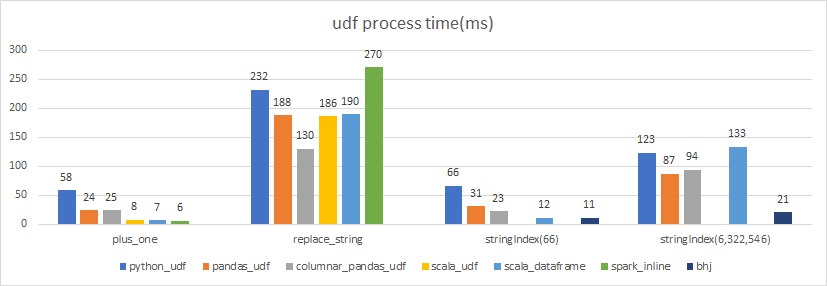

| 	                   | plus_one	        | replace_string	| stringIndex(66)	 |stringIndex(6,322,546)|
| :------------------- | ------------------ | ----------------- | ------------------ | -------------------- |
|python_udf	           |[0158_0](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=0)	            |[0158_10](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=10)	        |[0158_24](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=24)	         |[0158_36](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=36)               |
|pandas_udf	           |[0158_2](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=2)	            |[0158_12](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=12)	        |[0158_27](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=27)	         |[0158_39](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=39)               |
|columnar_pandas_udf   |[0159_0](http://sr602:18080/history/application_1626660109287_0159/SQL/execution/?id=0)	            |[0159_2](http://sr602:18080/history/application_1626660109287_0159/SQL/execution/?id=2)	            |[0159_5](http://sr602:18080/history/application_1626660109287_0159/SQL/execution/?id=5)	             |[0159_8](http://sr602:18080/history/application_1626660109287_0159/SQL/execution/?id=8)                |
|scala_udf	           |[0158_4](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=4)	            |[0158_14](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=14)	        | 	                 |                      |
|scala_dataframe	   |[0158_6](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=6)	            |[0158_16](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=16)	        |[0158_30](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=30)	         |[0158_42](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=42)               |
|spark_inline	       |[0158_8](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=8)	            |[0158_18](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=18)	        | 	                 |                      |
|bhj	 	 	         |  [0158_21](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=21)	            |[0158_33](http://sr602:18080/history/application_1626660109287_0158/SQL/execution/?id=33)            |                    |                      |

In [1]:
#!/env/bin/python

import init

import findspark
findspark.init()

import os
import pandas as pd
import numpy as np
from pyspark.sql import *
from pyspark import *
import pyspark.sql.functions as f
from pyspark.sql.types import *
from timeit import default_timer as timer
import logging
from pyrecdp.data_processor import *
from pyrecdp.utils import *
from pyspark.sql.functions import pandas_udf, PandasUDFType


def intUDFTest(df, proc, output_name, method="pandas_udf"):
    ops = []
    def python_plus_one(x):
        return x + 1
    
    if method == 'python_udf':
        ops.append(FeatureAdd(
            cols={'tweet': 'a'}, udfImpl=f.udf(python_plus_one)))
        
    elif method == 'pandas_udf':
        @pandas_udf('int')
        def pd_plus_one(v):
            v1s = []
            for index, token in v.items():
                v1s.append(python_plus_one(token))
            return pd.Series(v1s, dtype=int)
        ops.append(FeatureAdd(
            cols={'tweet': 'a'}, udfImpl=pd_plus_one))
        
    elif method == 'scala_udf':
        proc.spark.udf.registerJavaFunction("scala_plus_one","com.intel.recdp.ScalaUDFTestInt")
        ops.append(FeatureAdd(
            cols={'tweet': "f.expr('scala_plus_one(a)')"}, op='inline'))
        
    elif method == 'scala_df':
        ops.append(FeatureAdd(
            cols={'tweet': "f.col('a')"}, op='inline'))
        ops.append(ScalaDFTest(cols=['tweet'], method='int'))       
        
    elif method == 'spark_inline':
        ops.append(FeatureAdd(
            cols={'tweet': "f.col('a') + f.lit(1)"}, op='inline'))
    
    ops.append(DropFeature(['a']))

    # execute
    proc.reset_ops(ops)
    t1 = timer()
    df = proc.transform(df, name=output_name, df_cnt=626242930)
    t2 = timer()
    print(f"intUDFTest with [{method}] took %.3f secs" % (t2 - t1))

    return df

def stringUDFTest(df, proc, output_name, method="pandas_udf"):
    ops = []
    def python_replace_str(x):
        return "_".join([n for n in x.split('\t')])
    
    if method == 'python_udf':
        ops.append(FeatureAdd(
            cols={'tweet': 'a'}, udfImpl=f.udf(python_replace_str)))
        
    elif method == 'pandas_udf':
        @pandas_udf('string')
        def pd_replace_str(v):
            v1s = []
            for index, token in v.items():
                v1s.append(python_replace_str(token))
            return pd.Series(v1s, dtype=str)
        ops.append(FeatureAdd(
            cols={'tweet': 'a'}, udfImpl=pd_replace_str))
        
    elif method == 'scala_udf':
        proc.spark.udf.registerJavaFunction("scala_replace_str","com.intel.recdp.ScalaUDFTestStr")
        ops.append(FeatureAdd(
            cols={'tweet': "f.expr('scala_replace_str(a)')"}, op='inline'))
        
    elif method == 'scala_df':
        ops.append(FeatureAdd(
            cols={'tweet': "f.col('a')"}, op='inline'))
        ops.append(ScalaDFTest(cols=['tweet'], method='str'))       
        
    elif method == 'spark_inline':
        ops.append(FeatureAdd(
            cols={'tweet': "f.concat_ws('_', f.split(f.col('a'), '\t'))"}, op='inline'))
    
    ops.append(DropFeature(['a']))

    # execute
    proc.reset_ops(ops)
    t1 = timer()
    df = proc.transform(df, name=output_name, df_cnt=626242930)
    t2 = timer()
    print(f"stringUDFTest with [{method}] took %.3f secs" % (t2 - t1))

    return df

def broadcastUDFTest(df, proc, output_name, dict_df, method="pandas_udf"):
    ops = []
    if method == 'broadcast':
        ops.append(FeatureAdd(cols={'tweet': "f.col('a')"}, op='inline'))
        ops.append(Categorify(['tweet'], dict_dfs = [{'col_name': 'tweet', 'dict': dict_df}]))

    elif method == 'python_udf':
        t1 = timer()
        broadcast_handler = proc.spark.sparkContext.broadcast(dict((row['dict_col'], row['dict_col_id']) for row in dict_df.collect()))
        t2 = timer()
        print(f"broadcast for [{method}] took %.3f secs" % (t2 - t1))
        def python_replace_str(x):
            m = broadcast_handler.value
            if x in m:
                return m[x]
            else:
                return -1
        ops.append(FeatureAdd(
            cols={'tweet': 'a'}, udfImpl=f.udf(python_replace_str)))
        
    elif method == 'pandas_udf':
        t1 = timer()
        broadcast_handler = proc.spark.sparkContext.broadcast(dict((row['dict_col'], row['dict_col_id']) for row in dict_df.collect()))
        t2 = timer()
        print(f"broadcast for [{method}] took %.3f secs" % (t2 - t1))
        def python_replace_str(x):
            m = broadcast_handler.value
            if x in m:
                return m[x]
            else:
                return -1
        @pandas_udf('int')
        def pd_replace_str(v):
            v1s = []
            for index, token in v.items():
                v1s.append(python_replace_str(token))
            return pd.Series(v1s, dtype=int)
        ops.append(FeatureAdd(
            cols={'tweet': 'a'}, udfImpl=pd_replace_str))
        
    elif method == 'scala_df':
        ops.append(FeatureAdd(
            cols={'tweet': "f.col('a')"}, op='inline'))
        ops.append(ScalaDFTest(cols=['tweet'], dicts=[{'col_name': 'a', 'dict': dict_df}], method='broadcast'))       
    
    ops.append(DropFeature(['a']))

    # execute
    proc.reset_ops(ops)
    t1 = timer()
    df = proc.transform(df, name=output_name, df_cnt=626242930)
    t2 = timer()
    print(f"broadcastUDFTest with [{method}] took %.3f secs" % (t2 - t1))

    return df

/mnt/nvme2/chendi/BlueWhale/recdp


In [2]:
path_prefix = "hdfs://"
current_path = "/recsys2021_0608_udf_test/"
original_folder = "/recsys2021_0608/"

native_sql_path = "/mnt/nvme2/chendi/intel-bigdata/OAP/native-sql-engine/native-sql-engine/core/target/spark-columnar-core-1.2.0-snapshot-jar-with-dependencies.jar"
native_arrow_datasource_path = "/mnt/nvme2/chendi/intel-bigdata/OAP/native-sql-engine/arrow-data-source/standard/target/spark-arrow-datasource-standard-1.2.0-snapshot-jar-with-dependencies.jar"
scala_udf_jars = "/mnt/nvme2/chendi/BlueWhale/recdp/ScalaProcessUtils/target/recdp-scala-extensions-0.1.0-jar-with-dependencies.jar"

##### 1. Start spark and initialize data processor #####
t0 = timer()

#### vanilla spark ####
spark = SparkSession.builder.master('yarn')\
    .appName("udf_vanilla")\
    .config("spark.sql.broadcastTimeout", "7200")\
    .config("spark.cleaner.periodicGC.interval", "10min")\
    .config("spark.driver.extraClassPath", 
            f"{scala_udf_jars}")\
    .config("spark.executor.extraClassPath",
            f"{scala_udf_jars}")\
    .config("spark.executor.memory", "10g")\
    .config("spark.executor.memoryOverhead", "16g")\
    .getOrCreate()
proc = DataProcessor(spark, path_prefix,
                     current_path=current_path, shuffle_disk_capacity="1200GB", enable_gazelle=False)

##################################################################
#['python_udf', 'pandas_udf', 'scala_udf', 'scala_df', 'spark_inline']
for method in ['python_udf', 'pandas_udf', 'scala_udf', 'scala_df', 'spark_inline']:
    df = spark.read.format("parquet").load(path_prefix + original_folder)
    df = df.selectExpr("engaged_with_user_follower_count as a").withColumn("a", f.col("a").cast(IntegerType()))
    df = intUDFTest(df, proc, output_name="decoded_with_extracted_features", method=method)
    df.filter("tweet is not null").show(1)
for method in ['python_udf', 'pandas_udf', 'scala_udf', 'scala_df', 'spark_inline']:
    df = spark.read.format("parquet").load(path_prefix + original_folder)
    df = df.selectExpr("text_tokens as a")
    df = stringUDFTest(df, proc, output_name="decoded_with_extracted_features", method=method)
    df.filter("tweet is not null").show(1)
for method in ['broadcast', 'python_udf', 'pandas_udf', 'scala_df']:
    df = spark.read.format("parquet").load(path_prefix + original_folder)
    dict_df = spark.read.format("parquet").load("/recsys2021_0608_processed/recsys_dicts/language")
    df = df.selectExpr("language as a")
    df = broadcastUDFTest(df, proc, output_name="decoded_with_extracted_features", dict_df = dict_df, method=method)
    df.filter("tweet is not null").filter("tweet != -1").show(1)
for method in ['broadcast', 'python_udf', 'pandas_udf', 'scala_df']:
    df = spark.read.format("parquet").load("/recsys2021_0608_processed/first_hashtags")
    dict_df = spark.read.format("parquet").load("/recsys2021_0608_processed/recsys_dicts/hashtags")
    df = broadcastUDFTest(df, proc, output_name="decoded_with_extracted_features", dict_df = dict_df, method=method)
    df.filter("tweet is not null").filter("tweet != -1").show(1)

recdp-scala-extension is enabled
per core memory size is 2.500 GB and shuffle_disk maximum capacity is 1200.000 GB
intUDFTest with [python_udf] took 58.395 secs
+-----+
|tweet|
+-----+
|  986|
+-----+
only showing top 1 row

intUDFTest with [pandas_udf] took 24.093 secs
+-----+
|tweet|
+-----+
|32437|
+-----+
only showing top 1 row

intUDFTest with [scala_udf] took 7.559 secs
+-----+
|tweet|
+-----+
|32437|
+-----+
only showing top 1 row

intUDFTest with [scala_df] took 7.266 secs
+-----+
|tweet|
+-----+
|32437|
+-----+
only showing top 1 row

intUDFTest with [spark_inline] took 6.221 secs
+-----+
|tweet|
+-----+
|32437|
+-----+
only showing top 1 row

stringUDFTest with [python_udf] took 231.697 secs
+--------------------+
|               tweet|
+--------------------+
|101_56898_137_144...|
+--------------------+
only showing top 1 row

stringUDFTest with [pandas_udf] took 187.985 secs
+--------------------+
|               tweet|
+--------------------+
|101_56898_137_144...|
+-------

In [3]:
spark.stop()

In [2]:
path_prefix = "hdfs://"
current_path = "/recsys2021_0608_udf_test/"
original_folder = "/recsys2021_0608/"

native_sql_path = "/mnt/nvme2/chendi/intel-bigdata/OAP/native-sql-engine/native-sql-engine/core/target/spark-columnar-core-1.2.0-snapshot-jar-with-dependencies.jar"
native_arrow_datasource_path = "/mnt/nvme2/chendi/intel-bigdata/OAP/native-sql-engine/arrow-data-source/standard/target/spark-arrow-datasource-standard-1.2.0-snapshot-jar-with-dependencies.jar"
scala_udf_jars = "/mnt/nvme2/chendi/BlueWhale/recdp/ScalaProcessUtils/target/recdp-scala-extensions-0.1.0-jar-with-dependencies.jar"

##### 1. Start spark and initialize data processor #####
t0 = timer()
#### nativesql ####
spark = SparkSession.builder.master('yarn')\
    .appName("udf_native-sql")\
    .config("spark.sql.broadcastTimeout", "7200")\
    .config("spark.cleaner.periodicGC.interval", "10min")\
    .config("spark.executorEnv.LD_LIBRARY_PATH", "/usr/local/lib64/")\
    .config("spark.driver.extraClassPath", 
            f"{native_sql_path}:{native_arrow_datasource_path}:{scala_udf_jars}")\
    .config("spark.executor.extraClassPath",
            f"{native_sql_path}:{native_arrow_datasource_path}:{scala_udf_jars}")\
    .config("spark.sql.extensions", "com.intel.oap.ColumnarPlugin, com.intel.oap.spark.sql.ArrowWriteExtension")\
    .config("spark.shuffle.manager", "org.apache.spark.shuffle.sort.ColumnarShuffleManager")\
    .config("spark.executor.memory", "10g")\
    .config("spark.executor.memoryOverhead", "16g")\
    .config("spark.memory.offHeap.use", "true")\
    .config("spark.memory.offHeap.size", "12G")\
    .config("spark.executor.extraJavaOptions", "-XX:MaxDirectMemorySize=25G")\
    .config("spark.oap.sql.columnar.arrowudf", "true")\
    .getOrCreate()
proc = DataProcessor(spark, path_prefix,
                    current_path=current_path, shuffle_disk_capacity="1200GB", enable_gazelle=True)

##################################################################
#['python_udf', 'pandas_udf', 'scala_udf', 'scala_df', 'spark_inline']
for method in ['pandas_udf']:
    df = spark.read.format("arrow").load(path_prefix + original_folder)
    df = df.selectExpr("engaged_with_user_follower_count as a").withColumn("a", f.col("a").cast(IntegerType()))
    df = intUDFTest(df, proc, output_name="decoded_with_extracted_features", method=method)
    df.filter("tweet is not null").show(1)
for method in ['pandas_udf']:
    df = spark.read.format("arrow").load(path_prefix + original_folder)
    df = df.selectExpr("text_tokens as a")
    df = stringUDFTest(df, proc, output_name="decoded_with_extracted_features", method=method)
    df.filter("tweet is not null").show(1)
for method in ['pandas_udf']:
    df = spark.read.format("arrow").load(path_prefix + original_folder)
    dict_df = spark.read.format("arrow").load("/recsys2021_0608_processed/recsys_dicts/language")
    df = df.selectExpr("language as a")
    df = broadcastUDFTest(df, proc, output_name="decoded_with_extracted_features", dict_df = dict_df, method=method)
    df.filter("tweet is not null").filter("tweet != -1").show(1)
for method in ['pandas_udf']:
    df = spark.read.format("arrow").load(path_prefix + original_folder)
    dict_df = spark.read.format("arrow").load("/recsys2021_0608_processed/recsys_dicts/hashtags")
    df = df.withColumn("a", f.split(f.col('hashtags'), '\t').getItem(0)).select("a")
    df = df.repartition(200)
    df = broadcastUDFTest(df, proc, output_name="decoded_with_extracted_features", dict_df = dict_df, method=method)
    df.filter("tweet is not null").filter("tweet != -1").show(1)

recdp-scala-extension is enabled
per core memory size is 2.500 GB and shuffle_disk maximum capacity is 1200.000 GB
intUDFTest with [pandas_udf] took 24.533 secs
+-----+
|tweet|
+-----+
|32437|
+-----+
only showing top 1 row

stringUDFTest with [pandas_udf] took 129.790 secs
+--------------------+
|               tweet|
+--------------------+
|101_56898_137_144...|
+--------------------+
only showing top 1 row

broadcast for [pandas_udf] took 0.553 secs
broadcastUDFTest with [pandas_udf] took 22.516 secs
+-----+
|tweet|
+-----+
|   18|
+-----+
only showing top 1 row

broadcast for [pandas_udf] took 44.521 secs
broadcastUDFTest with [pandas_udf] took 49.415 secs
+-----+
|tweet|
+-----+
|26760|
+-----+
only showing top 1 row

